In [ ]:
import numpy as np
import re
import pickle
import nltk as tk
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.preprocessing import StandardScaler
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn import preprocessing
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

tk.download('stopwords')
tk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
suicide_dt = pd.read_csv(r'/content/drive/MyDrive/Suicide_Detection.csv')

In [ ]:
suicide_dt

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [ ]:
suicide_dt = suicide_dt.fillna(np.nan)
suicide_dt

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


#Exploratory Data Analysis

In [ ]:
suicide_dt.shape

(232074, 3)

In [ ]:
suicide_dt.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [ ]:
suicide_dt.describe()

,Unnamed: 0
count,232074.000000
mean,174152.863518
std,100500.425362
min,2.000000
25%,87049.250000
50%,174358.500000
75%,261285.750000
max,348110.000000


In [ ]:
suicide_dt['class'].value_counts() #count the number of rows for each class

non-suicide    116037
suicide        116037
Name: class, dtype: int64

In [ ]:
#To make figure size a bit larger
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.0
4.0


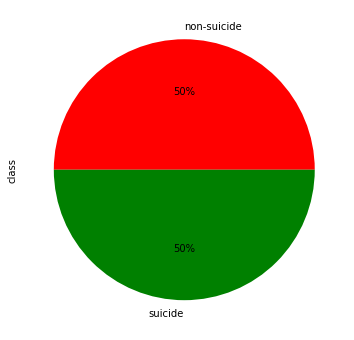

In [ ]:
suicide_dt['class'].value_counts().plot(kind='pie', autopct='%1.0f%%',colors=["red", "green"])

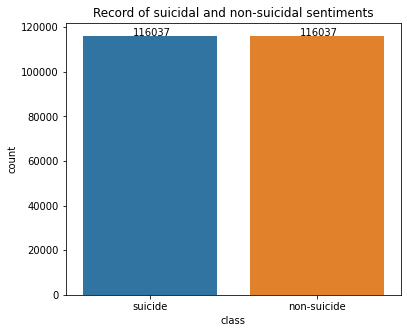

In [ ]:
#we have create a count plot to compare the number of suicidal and non-suicidal sentiments.
import seaborn as sn
%matplotlib inline
plt.figure(figsize=(6,5))
plt.title("Record of suicidal and non-suicidal sentiments")
plot = sn.countplot(x = 'class', data=suicide_dt)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+0.3 ,p.get_height()+80))

#Pre Processing Cleaning Data

In [ ]:
def text_cleaning(text):
    list_subreddit = []
    for reddit in range(len(text)):
        reddit = re.sub(r'\W', ' ', str(text[reddit])) #convertig byte-like object into string
      #since review has already str(X[i]) so we will keep using review 
        reddit = reddit.lower()
        reddit = re.sub(r'\s+[a-z]\s+', ' ',reddit) #removing single characters
        reddit = re.sub(r'^[a-z]\s+',' ', reddit) #removing single characters at the start of sentece I & space
        reddit = re.sub(r'\W',' ', reddit) # Removing special characters
        reddit = re.sub(r'\d',' ', reddit) #Removing digits
        reddit = re.sub(r'^\s+[a-z]$',' ', reddit)

        # Removing Contraction
        reddit = re.sub(r'https://t.co/[a-zA-Z0-9]*\s', ' ', reddit)
        reddit = re.sub(r'\s+https://t.co/[a-zA-Z0-9]*\s', ' ', reddit)
        reddit = re.sub(r'\s+https://t.co/[a-zA-Z0-9]*$', ' ', reddit)
        reddit  = re.sub(r"won't" ,"will not" , reddit)
        reddit  = re.sub(r"that's" ,"that is" , reddit)
        reddit = re.sub(r"what's","what is", reddit)
        reddit = re.sub(r"it's","it is", reddit)
        reddit = re.sub(r"who's","who is", reddit)
        reddit = re.sub(r"she's","she is", reddit)
        reddit = re.sub(r"i'm","i am", reddit)
        reddit = re.sub(r"he's","he is", reddit)
        reddit = re.sub(r"they're","they are", reddit)
        reddit = re.sub(r"ain't","am not", reddit)
        reddit = re.sub(r"wouldn't","would not", reddit)
        reddit = re.sub(r"shouldn't","should not", reddit)
        reddit = re.sub(r"can't","can not", reddit)
        reddit = re.sub(r"couldn't","could not", reddit)
        reddit = re.sub(r"won't","would not", reddit)
        list_subreddit.append(reddit)

    return list_subreddit

suicide_dt["list_subreddit"]= text_cleaning(suicide_dt["text"])


**Stop Words Removal**

Stop words are words(often very common words in a particular language) that do not add value to the meaning of a sentence or paragraph. Like- ‘You’, ‘This’, ‘That’, ‘The’ do not help in determining the sentiment of a given sentence.

In [ ]:
english_stop_words = tk.corpus.stopwords.words('english')
print(len(english_stop_words))
print (english_stop_words[:30])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself']


In [ ]:
def remove_stop_words(text):
    for word in english_stop_words:
        word = ' ' + word + ' '
        stopword = text.replace(word, ' ')
    return stopword
 
suicide_dt['New_Text'] = suicide_dt['list_subreddit'].apply(remove_stop_words)

In [ ]:
suicide_dt.head()

,Unnamed: 0,text,class,list_subreddit,New_Text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left my wi...,ex wife threatening suiciderecently left my wi...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am weird don get affected by compliments if it...,am weird don get affected by compliments if it...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so can never he...,finally is almost over so can never he...
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help me im crying so hard,need helpjust help me im crying so hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,so losthello my name is adam and ve bee...,so losthello my name is adam and ve bee...


In [ ]:
#Removing Rare Words
from collections import Counter
cnt = Counter()
cnt.most_common(10)
n_rare_words = 10
RAREWORDS = set([rare for (rare, rare_word) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

In [ ]:
suicide_dt["New_Text"] = suicide_dt["New_Text"].apply(lambda text: remove_rarewords(text))
suicide_dt.head()

,Unnamed: 0,text,class,list_subreddit,New_Text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left my wi...,ex wife threatening suiciderecently left my wi...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am weird don get affected by compliments if it...,am weird don get affected by compliments if it...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so can never he...,finally is almost over so can never hear has b...
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help me im crying so hard,need helpjust help me im crying so hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,so losthello my name is adam and ve bee...,so losthello my name is adam and ve been strug...


#Tokenization

Tokenization is the process of tokenizing or splitting a string, text into a list of tokens.

In [ ]:
#https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/
def identify_tokens(text):
    texts = text['New_Text']
    tokens = tk.word_tokenize(texts)
    token_words = [w for w in tokens]
    return token_words

suicide_dt['tokenized_words'] = suicide_dt.apply(identify_tokens, axis=1)

In [ ]:
suicide_dt.head()

,Unnamed: 0,text,class,list_subreddit,New_Text,tokenized_words
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left my wi...,ex wife threatening suiciderecently left my wi...,"[ex, wife, threatening, suiciderecently, left,..."
1,3,Am I weird I don't get affected by compliments...,non-suicide,am weird don get affected by compliments if it...,am weird don get affected by compliments if it...,"[am, weird, don, get, affected, by, compliment..."
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so can never he...,finally is almost over so can never hear has b...,"[finally, is, almost, over, so, can, never, he..."
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help me im crying so hard,need helpjust help me im crying so hard,"[need, helpjust, help, me, im, crying, so, hard]"
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,so losthello my name is adam and ve bee...,so losthello my name is adam and ve been strug...,"[so, losthello, my, name, is, adam, and, ve, b..."


#Stemming

Stemming is a process of bringing all different forms of a word to its root form so that machine looks at them as similar words.

In [ ]:

#Stemmer
def stem_words(text):
    stemmer = tk.porter.PorterStemmer()
    token_word = text["tokenized_words"]
    return ' '.join([stemmer.stem(token) for token in token_word])
    return token_word
 
suicide_dt['word_stemmer'] = suicide_dt.apply(stem_words,axis=1)

In [ ]:
suicide_dt.head()

,Unnamed: 0,text,class,list_subreddit,New_Text,tokenized_words,word_stemmer
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left my wi...,ex wife threatening suiciderecently left my wi...,"[ex, wife, threatening, suiciderecently, left,...",ex wife threaten suiciderec left my wife for g...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am weird don get affected by compliments if it...,am weird don get affected by compliments if it...,"[am, weird, don, get, affected, by, compliment...",am weird don get affect by compliment if it co...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so can never he...,finally is almost over so can never hear has b...,"[finally, is, almost, over, so, can, never, he...",final is almost over so can never hear ha been...
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help me im crying so hard,need helpjust help me im crying so hard,"[need, helpjust, help, me, im, crying, so, hard]",need helpjust help me im cri so hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,so losthello my name is adam and ve bee...,so losthello my name is adam and ve been strug...,"[so, losthello, my, name, is, adam, and, ve, b...",so losthello my name is adam and ve been strug...


In [ ]:
# Removing extra columns
suicide_dt.drop(["New_Text"], axis=1, inplace=True)

In [ ]:
suicide_dt.head(10)

,Unnamed: 0,text,class,list_subreddit,tokenized_words,word_stemmer
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left my wi...,"[ex, wife, threatening, suiciderecently, left,...",ex wife threaten suiciderec left my wife for g...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am weird don get affected by compliments if it...,"[am, weird, don, get, affected, by, compliment...",am weird don get affect by compliment if it co...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so can never he...,"[finally, is, almost, over, so, can, never, he...",final is almost over so can never hear ha been...
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help me im crying so hard,"[need, helpjust, help, me, im, crying, so, hard]",need helpjust help me im cri so hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,so losthello my name is adam and ve bee...,"[so, losthello, my, name, is, adam, and, ve, b...",so losthello my name is adam and ve been strug...
5,11,Honetly idkI dont know what im even doing here...,suicide,honetly idki dont know what im even doing here...,"[honetly, idki, dont, know, what, im, even, do...",honetli idki dont know what im even do here ju...
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide,trigger warning excuse for self inflicted bu...,"[trigger, warning, excuse, for, self, inflicte...",trigger warn excus for self inflict burn do kn...
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide,it ends tonight can do it anymore quit,"[it, ends, tonight, can, do, it, anymore, quit]",it end tonight can do it anymor quit
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,everyone wants to be edgy and it making me s...,"[everyone, wants, to, be, edgy, and, it, makin...",everyon want to be edgi and it make me self co...
9,18,My life is over at 20 years oldHello all. I am...,suicide,my life is over at years oldhello all am ...,"[my, life, is, over, at, years, oldhello, all,...",my life is over at year oldhello all am year o...


#Label Encoding

In [ ]:
#Label Encoding refers to converting the labels into a numeric form 
#https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

suicide_dt['target_variable']= label_encoder.fit_transform(suicide_dt['class'])

suicide_dt.head()

,Unnamed: 0,text,class,list_subreddit,tokenized_words,word_stemmer,target_variable
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left my wi...,"[ex, wife, threatening, suiciderecently, left,...",ex wife threaten suiciderec left my wife for g...,1
1,3,Am I weird I don't get affected by compliments...,non-suicide,am weird don get affected by compliments if it...,"[am, weird, don, get, affected, by, compliment...",am weird don get affect by compliment if it co...,0
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so can never he...,"[finally, is, almost, over, so, can, never, he...",final is almost over so can never hear ha been...,0
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help me im crying so hard,"[need, helpjust, help, me, im, crying, so, hard]",need helpjust help me im cri so hard,1
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,so losthello my name is adam and ve bee...,"[so, losthello, my, name, is, adam, and, ve, b...",so losthello my name is adam and ve been strug...,1


#Persisting The Dataset

In [ ]:
#using pickle to load our dataset faster
with open('suicide_pickle.pickle', 'wb') as f: # we are creating pickle files for Suicide_dt, wb is for bytes
    pickle.dump(suicide_dt,f)
    
with open('suicide_pickle.pickle', 'rb') as f:
    p_suicide_dt = pickle.load(f)

In [ ]:
#Spliting document and target variable into different variables
X = p_suicide_dt['word_stemmer']
Y = p_suicide_dt['target_variable']

In [ ]:
X.head()

0    ex wife threaten suiciderec left my wife for g...
1    am weird don get affect by compliment if it co...
2    final is almost over so can never hear ha been...
3                 need helpjust help me im cri so hard
4    so losthello my name is adam and ve been strug...
Name: word_stemmer, dtype: object

In [ ]:
Y.head()

0    1
1    0
2    0
3    1
4    1
Name: target_variable, dtype: int64

**Spliting Into Train and Test**

In [ ]:

#text_train is to train our data, text_test is our test data
#sent_train is our classes associated with text_train, similar for sent_test
text_train, text_test, sent_train, sent_test = train_test_split(X,Y,test_size=0.33,random_state=0)

#Build Model for Suicide classification

**1. Bag Of Words (BOW)**

In [ ]:
import sklearn
vectorizer = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
tf_features_train = vectorizer.fit_transform(text_train)
tf_features_test = vectorizer.transform(text_test)
print (tf_features_train.shape)

(155489, 97830)


#Model Training For Bag Of Words (BOW)

**1. Logistic Regression for BOW**

In [ ]:
classifier = LogisticRegression()
classifier.fit(tf_features_train, sent_train)

In [ ]:
lrbow_predictions = classifier.predict(tf_features_test)

In [ ]:
from sklearn.metrics import accuracy_score
dt_ac = accuracy_score(sent_test,lrbow_predictions) 
dt_ac

0.9294639942547496

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(sent_test,lrbow_predictions))
print(classification_report(sent_test,lrbow_predictions))
print(accuracy_score(sent_test, lrbow_predictions))

[[36526  1836]
 [ 3566 34657]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     38362
           1       0.95      0.91      0.93     38223

    accuracy                           0.93     76585
   macro avg       0.93      0.93      0.93     76585
weighted avg       0.93      0.93      0.93     76585

0.9294639942547496


In [ ]:
sent_train.unique() 

array([1, 0])

In [ ]:
confusion_matrix(sent_test,lrbow_predictions)

array([[36526,  1836],
       [ 3566, 34657]])

In [ ]:
unique_labels(sent_test) #There are 2 unique categories in this classification problem and that is why we have 2 rows and 2 columns

array([0, 1])

In [ ]:
def plot(y_true, y_pred):
  labels = unique_labels(sent_test)
  cloumn = ['Predicted' for label in labels]
  indices = ['Actual' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=cloumn,index = indices)
  return sns.heatmap(table, annot=True, fmt='d',cmap='viridis')

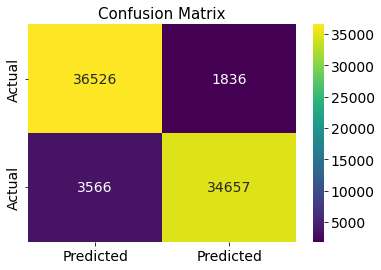

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 14
plt.title("Confusion Matrix", fontsize= 15)
plot(sent_test,lrbow_predictions)
plt.show()

**2. Decision Tree for BOW**

In [ ]:
dt_classifer = DecisionTreeClassifier()
#training
dt_classifer.fit(tf_features_train,sent_train) #training data and training label (target variable)

DecisionTreeClassifier()

In [ ]:
dtbow_predictions = dt_classifer.predict(tf_features_test)

In [ ]:
dt_ac = accuracy_score(sent_test,dtbow_predictions) 
dt_ac

0.8609910556897565

In [ ]:

print(confusion_matrix(sent_test,dtbow_predictions))
print(classification_report(sent_test,dtbow_predictions))
print(accuracy_score(sent_test, dtbow_predictions))

[[33096  5266]
 [ 5380 32843]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     38362
           1       0.86      0.86      0.86     38223

    accuracy                           0.86     76585
   macro avg       0.86      0.86      0.86     76585
weighted avg       0.86      0.86      0.86     76585

0.8609910556897565


In [ ]:
def plot(y_true, y_pred):
  labels = unique_labels(sent_test)
  cloumn = ['Predicted' for label in labels]
  indices = ['Actual' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=cloumn,index = indices)
  return sns.heatmap(table, annot=True, fmt='d',cmap='viridis')

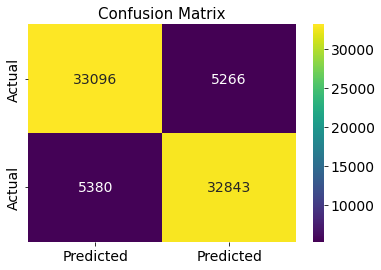

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 14
plt.title("Confusion Matrix", fontsize= 15)
plot(sent_test,dtbow_predictions)
plt.show()

**3. Random Forest for BOW**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier()
forest_classifier.fit(tf_features_train,sent_train)

RandomForestClassifier()

In [ ]:
forestBow_predictions = forest_classifier.predict(tf_features_test)

In [ ]:
forest_ac = accuracy_score(sent_test,forestBow_predictions) 
forest_ac

0.8834758764771169

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(sent_test,forestBow_predictions))
print(classification_report(sent_test,forestBow_predictions))
print(accuracy_score(sent_test, forestBow_predictions))

[[33508  4854]
 [ 4070 34153]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     38362
           1       0.88      0.89      0.88     38223

    accuracy                           0.88     76585
   macro avg       0.88      0.88      0.88     76585
weighted avg       0.88      0.88      0.88     76585

0.8834758764771169


In [ ]:
def plot(y_true, y_pred):
  labels = unique_labels(sent_test)
  cloumn = ['Predicted' for label in labels]
  indices = ['Actual' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=cloumn,index = indices)
  return sns.heatmap(table, annot=True, fmt='d',cmap='viridis')

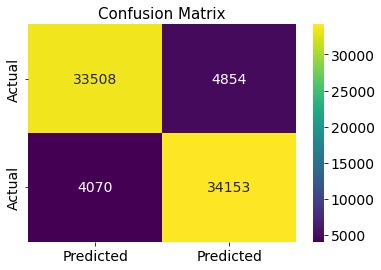

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 14
plt.title("Confusion Matrix", fontsize= 15)
plot(sent_test,forestBow_predictions)
plt.show()

**4. Naive Bayes for BOW**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_classifer = MultinomialNB()
naive_classifer = naive_classifer.fit(tf_features_train,sent_train)

In [ ]:
naiveBow_predictions = naive_classifer.predict(tf_features_test)

In [ ]:
naive_ac = accuracy_score(sent_test,naiveBow_predictions) 
naive_ac

0.8958151073970099

In [ ]:

print(confusion_matrix(sent_test,naiveBow_predictions))
print(classification_report(sent_test,naiveBow_predictions))
print(accuracy_score(sent_test, naiveBow_predictions))

[[31892  6470]
 [ 1509 36714]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     38362
           1       0.85      0.96      0.90     38223

    accuracy                           0.90     76585
   macro avg       0.90      0.90      0.90     76585
weighted avg       0.90      0.90      0.90     76585

0.8958151073970099


In [ ]:
def plot(y_true, y_pred):
  labels = unique_labels(sent_test)
  cloumn = ['Predicted' for label in labels]
  indices = ['Actual' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=cloumn,index = indices)
  return sns.heatmap(table, annot=True, fmt='d',cmap='viridis')

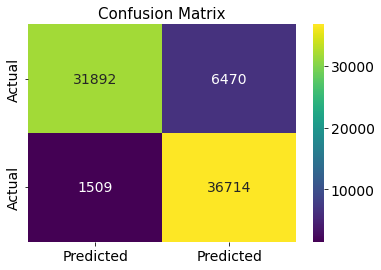

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 14
plt.title("Confusion Matrix", fontsize= 15)
plot(sent_test,naiveBow_predictions)
plt.show()

**2. TF-IDF**

In [ ]:
import sklearn
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(binary=False,ngram_range=(1,1))
tf_features_train = vectorizer.fit_transform(text_train)
tf_features_test = vectorizer.transform(text_test)
print (tf_features_train.shape)

(155489, 97830)


# Model Training For TF-IDF

**1. Logistic Regression for TF-IDF**

In [ ]:
classifier = LogisticRegression()
classifier.fit(tf_features_train, sent_train)

In [ ]:
lrTfidf_predictions = classifier.predict(tf_features_test)

In [ ]:
from sklearn.metrics import accuracy_score
dt_ac = accuracy_score(sent_test,lrTfidf_predictions) 
dt_ac

0.9367630737089508

In [ ]:

print(confusion_matrix(sent_test,lrTfidf_predictions))
print(classification_report(sent_test,lrTfidf_predictions))
print(accuracy_score(sent_test, lrTfidf_predictions))

[[36188  2174]
 [ 2669 35554]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     38362
           1       0.94      0.93      0.94     38223

    accuracy                           0.94     76585
   macro avg       0.94      0.94      0.94     76585
weighted avg       0.94      0.94      0.94     76585

0.9367630737089508


In [ ]:
def plot(y_true, y_pred):
  labels = unique_labels(sent_test)
  cloumn = ['Predicted' for label in labels]
  indices = ['Actual' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=cloumn,index = indices)
  return sns.heatmap(table, annot=True, fmt='d',cmap='viridis')

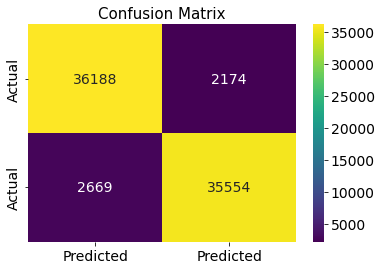

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 14
plt.title("Confusion Matrix", fontsize= 15)
plot(sent_test,lrTfidf_predictions)
plt.show()

**2. Decision Tree for TF-IDF**

In [ ]:
dt_classifer = DecisionTreeClassifier()
#training
dt_classifer.fit(tf_features_train,sent_train) #training data and training label (target variable)

DecisionTreeClassifier()

In [ ]:
dtTfidf_predictions = dt_classifer.predict(tf_features_test)

In [ ]:
dt_ac = accuracy_score(sent_test,dtTfidf_predictions) 
dt_ac

0.8565515440360384

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(sent_test,dtTfidf_predictions))
print(classification_report(sent_test,dtTfidf_predictions))
print(accuracy_score(sent_test, dtTfidf_predictions))

[[32823  5539]
 [ 5447 32776]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     38362
           1       0.86      0.86      0.86     38223

    accuracy                           0.86     76585
   macro avg       0.86      0.86      0.86     76585
weighted avg       0.86      0.86      0.86     76585

0.8565515440360384


In [ ]:
def plot(y_true, y_pred):
  labels = unique_labels(sent_test)
  cloumn = ['Predicted' for label in labels]
  indices = ['Actual' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=cloumn,index = indices)
  return sns.heatmap(table, annot=True, fmt='d',cmap='viridis')

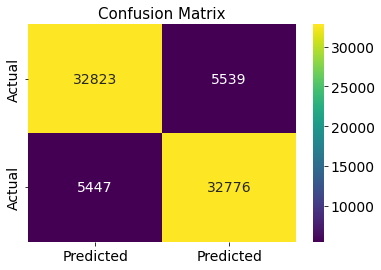

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 14
plt.title("Confusion Matrix", fontsize= 15)
plot(sent_test,dtTfidf_predictions)
plt.show()

**3. Random Forest for TF-IDF**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier()
forest_classifier.fit(tf_features_train,sent_train)

RandomForestClassifier()

In [ ]:
forestTfidf_predictions = forest_classifier.predict(tf_features_test)

In [ ]:
forest_ac = accuracy_score(sent_test,forestTfidf_predictions) 
forest_ac

0.8930991708559117

In [ ]:

print(confusion_matrix(sent_test,forestTfidf_predictions))
print(classification_report(sent_test,forestTfidf_predictions))
print(accuracy_score(sent_test, forestTfidf_predictions))

[[34186  4176]
 [ 4011 34212]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     38362
           1       0.89      0.90      0.89     38223

    accuracy                           0.89     76585
   macro avg       0.89      0.89      0.89     76585
weighted avg       0.89      0.89      0.89     76585

0.8930991708559117


In [ ]:
def plot(y_true, y_pred):
  labels = unique_labels(sent_test)
  cloumn = ['Predicted' for label in labels]
  indices = ['Actual' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=cloumn,index = indices)
  return sns.heatmap(table, annot=True, fmt='d',cmap='viridis')

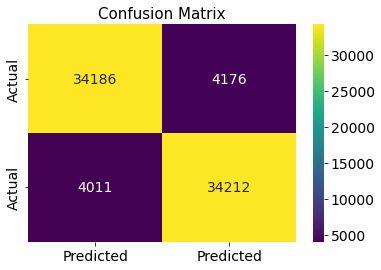

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 14
plt.title("Confusion Matrix", fontsize= 15)
plot(sent_test,forestTfidf_predictions)
plt.show()

**4. Naive Bayes for TF-IDF**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_classifer = MultinomialNB()
naive_classifer = naive_classifer.fit(tf_features_train,sent_train)

In [ ]:
naiveTfidf_predictions = naive_classifer.predict(tf_features_test)

In [ ]:
naive_ac = accuracy_score(sent_test,naiveTfidf_predictions) 
naive_ac

0.8785140693347261

In [ ]:
print(confusion_matrix(sent_test,naiveTfidf_predictions))
print(classification_report(sent_test,naiveTfidf_predictions))
print(accuracy_score(sent_test, naiveTfidf_predictions))

[[30092  8270]
 [ 1034 37189]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     38362
           1       0.82      0.97      0.89     38223

    accuracy                           0.88     76585
   macro avg       0.89      0.88      0.88     76585
weighted avg       0.89      0.88      0.88     76585

0.8785140693347261


In [ ]:
def plot(y_true, y_pred):
  labels = unique_labels(sent_test)
  cloumn = ['Predicted' for label in labels]
  indices = ['Actual' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=cloumn,index = indices)
  return sns.heatmap(table, annot=True, fmt='d',cmap='viridis')

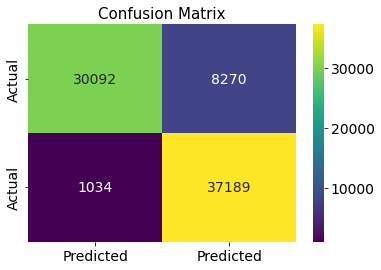

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams["font.size"]= 14
plt.title("Confusion Matrix", fontsize= 15)
plot(sent_test,naiveTfidf_predictions)
plt.show()